In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf


In [141]:
def calculate_ema(series, length):
    """
    Calculate Exponential Moving Average (EMA) for a Pandas Series.
    
    Args:
    - series (pd.Series): The data for which EMA is to be calculated (e.g., 'close' prices).
    - length (int): The period length for EMA (e.g., 10 for EMA_10).
    
    Returns:
    - pd.Series: EMA values.
    """
    alpha = 2 / (length + 1)
    ema = series.ewm(alpha=alpha, adjust=False).mean()
    return ema

# Example usage
#df['EMA_10'] = calculate_ema(df['close'], length=10)

def calculate_rsi(series, length=14):
    """
    Calculate Relative Strength Index (RSI) for a Pandas Series.
    
    Args:
    - series (pd.Series): The data for which RSI is to be calculated (e.g., 'close' prices).
    - length (int): The period length for RSI (default is 14).
    
    Returns:
    - pd.Series: RSI values.
    """
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)  # Positive changes
    loss = -delta.where(delta < 0, 0)  # Negative changes (converted to positive)
    
    avg_gain = gain.rolling(window=length, min_periods=length).mean()
    avg_loss = loss.rolling(window=length, min_periods=length).mean()
    
    # Use exponentially weighted moving average for smoothing (optional, common in practice)
    avg_gain = avg_gain.ewm(com=length - 1, adjust=False).mean()
    avg_loss = avg_loss.ewm(com=length - 1, adjust=False).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Example usage
#df['RSI'] = calculate_rsi(df['close'], length=14)


def calculate_macd(series, fast_length=12, slow_length=26, signal_length=9):
    """
    Calculate MACD (Moving Average Convergence Divergence) for a Pandas Series.
    
    Args:
    - series (pd.Series): The data for which MACD is to be calculated (e.g., 'close' prices).
    - fast_length (int): The period for the fast EMA (default is 12).
    - slow_length (int): The period for the slow EMA (default is 26).
    - signal_length (int): The period for the signal line EMA (default is 9).
    
    Returns:
    - pd.DataFrame: DataFrame containing MACD line, signal line, and histogram.
    """
    fast_ema = series.ewm(span=fast_length, adjust=False).mean()
    slow_ema = series.ewm(span=slow_length, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_length, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return pd.DataFrame({
        'MACD': macd_line,
        'Signal': signal_line,
        'Histogram': histogram
    })

# Example usage
#macd = calculate_macd(df['close'])
#df['MACD'] = macd['MACD']
#df['Signal'] = macd['Signal']
#df['Histogram'] = macd['Histogram']



In [142]:
# Inputs from Ginger
test_days=200
train_days=1000
trade_window=5
end_date = "2024-09-11"


df = pd.read_pickle("Screened_FRES.pkl")
df

,open,high,low,close,volume,labels
date,,,,,,
2019-07-19,830.0,842.600,794.8000,794.8,3545840,0
2019-07-22,798.0,811.400,775.2000,792.4,1788890,0
2019-07-23,795.8,804.600,778.2000,786.6,1303367,0
2019-07-24,787.2,787.279,767.0000,782.6,1373274,0
2019-07-25,788.8,800.000,777.6000,784.6,2019459,0
...,...,...,...,...,...,...
2024-09-12,528.5,540.000,522.2850,537.5,2841609,0
2024-09-13,549.5,578.500,545.7507,568.0,1349909,0
2024-09-16,566.5,584.000,565.0000,574.0,669592,0


In [208]:
def create_sequences_multifeature(data, target_feature, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])  # Collect the window of all features
        y.append(data[i + window_size, target_feature])  # Predict only the target feature (e.g., "high")
    return np.array(X), np.array(y)


# Add indicators to the DataFrame
df['SMA_10'] = df['high'].rolling(window=10).mean()
df['EMA_10'] = calculate_ema(df['high'], length=10)  # Exponential Moving Average (10 periods)
df['RSI'] = calculate_rsi(df['high'], length=14)     # Relative Strength Index (14 periods)
macd = calculate_macd(df['high'])
df['MACD'] = macd['MACD']
df['Signal'] = macd['Signal']
df['Histogram'] = macd['Histogram']
df['pct_change_high'] = df['high'].pct_change()
# Rolling standard deviation (volatility)
df['volatility'] = df['high'].rolling(window=5).std()
# Prepare the dataset
#features = df[["open", "high", "low", "close"]].values  # Shape (num_samples, 4)
# Detrended price
rolling_mean = df['high'].rolling(window=14).mean()
df['dpo'] = df['high'] - rolling_mean.shift(14 // 2)


#df2=df.dropna()
df2 = df.iloc[100:-trade_window]

features = df2[[ 'high', 'pct_change_high']].values
#features = df2[[ 'high',  'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Signal', 'Histogram']].values
#features = df2[['open', 'high', 'low', 'close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Signal', 'Histogram']].values



target_feature_index = 0  # Index of "high" in the features array


# Normalize the data (optional but recommended)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler()
#features_normalized = scaler.fit_transform(features)

# Scaler for input features (open, high, low, close)
feature_scaler = MinMaxScaler()
features_normalized = feature_scaler.fit_transform(features)

# Scaler for target feature (high)
target_scaler = MinMaxScaler()
high_normalized = target_scaler.fit_transform(features[:, target_feature_index].reshape(-1, 1))  # Only scale "high"


# Create sequences
window_size = 25
X, y = create_sequences_multifeature(features_normalized, target_feature_index, window_size)

# Adjust X shape for the GRU model (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Shape (num_samples, window_size, num_features)


In [209]:
#split = int(0.855 * len(X))


#X_train, X_test = X[:train_days], X[train_days:]
#y_train, y_test = y[:train_days], y[train_days:]

#len(X)
df2
#features[:, 0]

,open,high,low,close,volume,labels,SMA_10,EMA_10,RSI,MACD,Signal,Histogram,EMA_3,pct_change_high,volatility,dpo
date,,,,,,,,,,,,,,,,
2019-12-09,563.6,566.9999,549.800,558.2,1877138,0,580.01878,582.945670,32.589891,-26.750230,-25.404803,-1.345427,582.945670,-0.003165,12.299126,-55.300850
2019-12-10,551.2,562.8000,548.000,554.4,2175933,0,577.85878,579.282821,32.339301,-26.717139,-25.667270,-1.049869,579.282821,-0.007407,8.107538,-52.678857
2019-12-11,558.8,586.2000,557.600,581.6,2372696,0,576.86864,580.540490,32.981089,-24.520078,-25.437832,0.917754,580.540490,0.041578,8.958359,-23.607429
2019-12-12,578.0,596.0000,572.567,590.4,2044570,0,578.80864,583.351310,34.033425,-21.737537,-24.697773,2.960236,583.351310,0.016718,14.238977,-9.278857
2019-12-13,579.6,605.4000,569.000,572.4,2412885,0,581.51999,587.360163,35.858615,-18.559904,-23.470199,4.910295,587.360163,0.015772,18.329561,4.664000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-05,502.0,518.2003,502.000,513.0,503640,0,546.51164,541.291032,41.076859,-12.415443,-10.183147,-2.232296,541.291032,0.007574,19.969405,-32.571364
2024-09-06,514.5,517.6167,504.820,508.5,506860,0,542.90620,536.986608,40.587439,-13.571749,-10.860868,-2.710882,536.986608,-0.001126,16.928666,-33.797821
2024-09-09,512.0,513.5000,503.000,504.5,325095,1,538.55620,532.716316,39.906682,-14.651422,-11.618978,-3.032443,532.716316,-0.007953,13.832580,-39.271664


In [210]:
from keras.layers import Input, GRU, Dropout, Dense, Attention, GlobalAveragePooling1D
from keras.models import Model

# Input Layer
input_layer = Input(shape=(X.shape[1], X.shape[2]))

# GRU Layers with Dropout
gru_output = GRU(50, return_sequences=True)(input_layer)
gru_output = Dropout(0.2)(gru_output)

gru_output = GRU(50, return_sequences=True)(gru_output)
gru_output = Dropout(0.2)(gru_output)

gru_output = GRU(50, return_sequences=True)(gru_output)
gru_output = Dropout(0.2)(gru_output)

gru_output = GRU(50, return_sequences=True)(gru_output)
gru_output = Dropout(0.2)(gru_output)

# Attention Layer
attention_output = Attention()([gru_output, gru_output])

# Global Average Pooling Layer
pooled_output = GlobalAveragePooling1D()(attention_output)

# Fully Connected Output Layer
output_layer = Dense(1)(pooled_output)

# Define Model
attention_model = Model(inputs=input_layer, outputs=output_layer)
attention_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

attention_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 25, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_64 (GRU)        │ (None, 25, 50)    │      8,100 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 25, 50)    │          0 │ gru_64[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_65 (GRU)        │ (None, 25, 50)    │     15,300 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 25, 50)    │          0 │ gru_65[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_66 (GRU)        │ (None, 25, 50)    │     15,300 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 25, 50)    │          0 │ gru_66[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_67 (GRU)        │ (None, 25, 50)    │     15,300 │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 25, 50)    │          0 │ gru_67[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_16        │ (None, 25, 50)    │          0 │ dropout_67[0][0], │
│ (Attention)         │                   │            │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 50)        │          0 │ attention_16[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         51 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,051 (211.14 KB)

 Trainable params: 54,051 (211.14 KB)

 Non-trainable params: 0 (0.00 B)

In [211]:
#gru_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=30, batch_size=24, verbose=1)

history = attention_model.fit(
    X, y,
    #validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0017 - loss: 0.0313
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 3.2902e-04 - loss: 0.0058
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0055 - loss: 0.0057
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 6.6487e-04 - loss: 0.0080
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0039 - loss: 0.0053
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 9.6085e-04 - loss: 0.0059
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0021 - loss: 0.0049
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0017 - loss: 0.0048
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 3.8843e-04 - loss: 0.0045
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0023 - loss: 0.0043
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0018 - loss: 0.0042
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


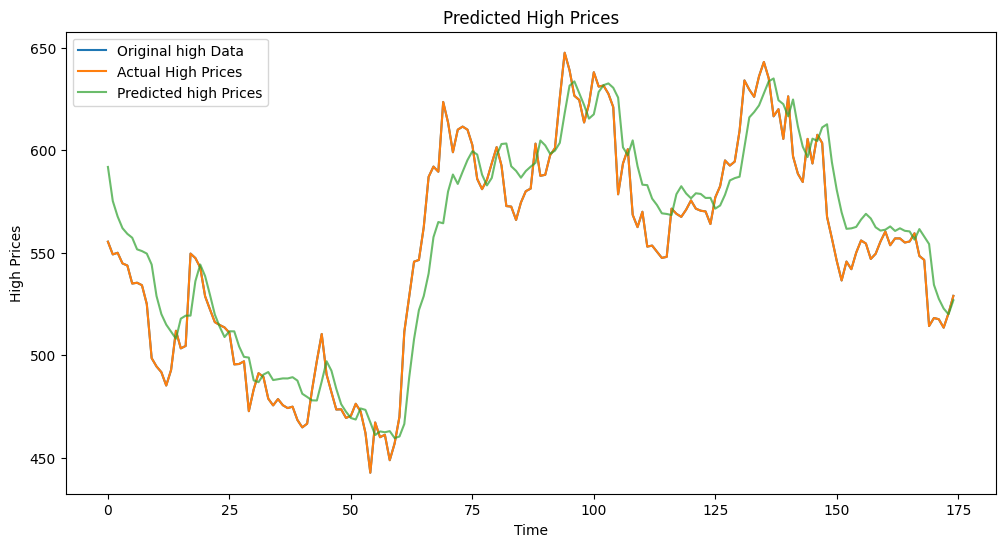

In [212]:
import matplotlib.pyplot as plt

# Predict
predicted_gru = attention_model.predict(X)

# Inverse transform the predicted and actual values
predicted_gru_actual = target_scaler.inverse_transform(predicted_gru)  # Use target scaler for "high"
y_test_actual = target_scaler.inverse_transform(y.reshape(-1, 1))  # Reshape y_test to (num_samples, 1)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

original_sample = df2['high'].values[1025:]  # Replace 'high' with your target feature
# Plot original data
plt.plot(original_sample, label="Original high Data")

plt.plot(y_test_actual[1000:], label="Actual High Prices")
plt.plot(predicted_gru_actual[1000:], label="Predicted high Prices", alpha=0.7)
plt.legend()
plt.title("Predicted High Prices")
plt.xlabel("Time")
plt.ylabel("High Prices")
plt.show()
#y_test_actual[1000:]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0017 - loss: 4.5267e-04 
Test Accuracy: 0.00


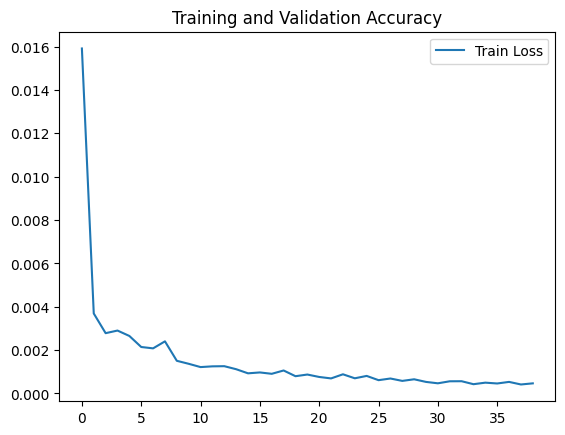

In [153]:
# Evaluate the model
loss, accuracy = attention_model.evaluate(X, y)
print(f"Test Accuracy: {accuracy:.2f}")

# Visualize results
#import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [161]:
# Use the last `window_size` days from the normalized dataset
last_window = features_normalized[-window_size:]  # Shape: (window_size, num_features)

# Reshape for the GRU model input: (1, window_size, num_features)
input_sequence = last_window.reshape((1, last_window.shape[0], last_window.shape[1]))

# List to store predictions
future_predictions = []

# Predict the next 5 days
for _ in range(5):  # Adjust the range for the desired number of days
    # Predict the next value for the target feature
    predicted_value = attention_model.predict(input_sequence, verbose=0)  # Shape: (1, 1)
    
    # Create a new feature vector for the predicted day
    new_day = input_sequence[0, -1, :].copy()  # Start with the last timestep
    #print(new_day)
    new_day[target_feature_index] = predicted_value[0, 0]  # Replace target feature with the prediction
    #print(predicted_value[0, 0])
    # Update the input sequence
    input_sequence = np.append(input_sequence[0, 1:, :], [new_day], axis=0)  # Shape: (window_size, num_features)
    #print(input_sequence)
    input_sequence = input_sequence.reshape((1, input_sequence.shape[0], input_sequence.shape[1]))
    #print(input_sequence)
    # Store the predicted value (scaled back if needed)
    future_predictions.append(predicted_value[0, 0])

# Inverse transform the predictions (if data was scaled)
future_predictions_scaled = target_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Future Predictions (scaled back):", future_predictions_scaled)


Future Predictions (scaled back): [[539.6943]
 [538.5291]
 [538.0544]
 [537.4926]
 [536.8236]]


In [150]:
df2.tail(10)


,open,high,low,close,volume,labels,SMA_10,EMA_10,RSI,MACD,Signal,Histogram
date,,,,,,,,,,,,
2024-08-29,553.5,555.5000,545.00,554.5,1140058,0,554.50245,555.973326,41.381595,-8.831107,-10.488437,1.657330
2024-08-30,559.5,559.5000,536.00,541.5,1178053,0,555.00245,556.614539,42.044384,-7.963693,-9.983488,2.019795
2024-09-02,541.0,548.4400,531.50,542.0,1930257,0,555.14645,555.128259,42.529409,-8.075620,-9.601914,1.526295
2024-09-03,540.0,546.5000,511.50,511.5,884926,0,554.84645,553.559485,42.683511,-8.226039,-9.326739,1.100700
2024-09-04,507.5,514.3050,503.00,508.5,772517,0,550.72695,546.422306,41.773039,-10.818408,-9.625073,-1.193335
2024-09-05,502.0,518.2003,502.00,513.0,503640,0,546.51164,541.291032,41.076859,-12.415443,-10.183147,-2.232296
2024-09-06,514.5,517.6167,504.82,508.5,506860,0,542.90620,536.986608,40.587439,-13.571749,-10.860868,-2.710882
2024-09-09,512.0,513.5000,503.00,504.5,325095,1,538.55620,532.716316,39.906682,-14.651422,-11.618978,-3.032443
2024-09-10,508.0,520.5050,506.50,514.0,485358,1,534.90670,530.496076,39.291166,-14.771548,-12.249492,-2.522055


In [156]:
# Verify the inverse transformation matches the original scale
scaled_sample = features_normalized[:, target_feature_index][:5]
original_sample = df2['high'].values[:5]  # Replace 'high' with your target feature

inverse_transformed_sample = target_scaler.inverse_transform(scaled_sample.reshape(-1, 1)).flatten()
print("Original Sample:", original_sample)
print("Inverse-Transformed Sample:", inverse_transformed_sample)
df2['high'].values[-5:]

Original Sample: [566.9999 562.8    586.2    596.     605.4   ]
Inverse-Transformed Sample: [582.94566976 579.28282071 580.54048967 583.35130973 587.36016251]


array([518.2003, 517.6167, 513.5   , 520.505 , 529.    ])

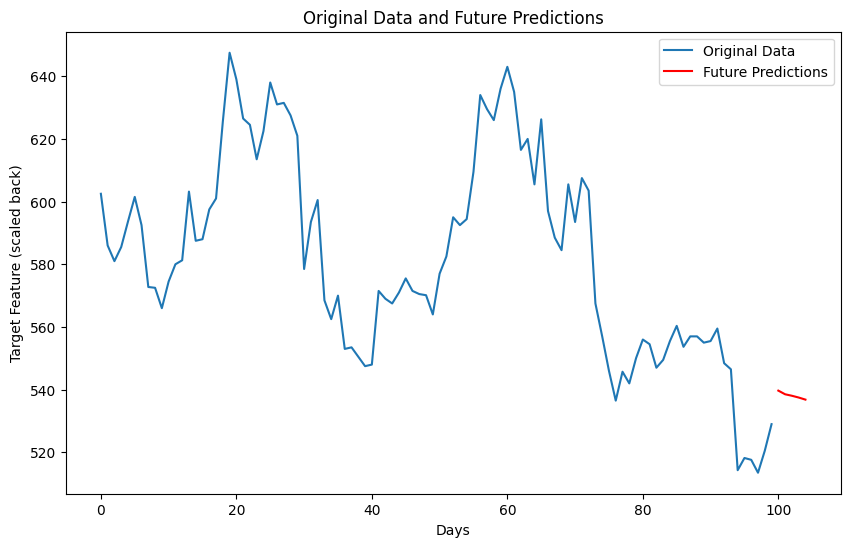

range(100, 105)

In [155]:
##### Original data (scaled back)

#original_data_scaled = target_scaler.inverse_transform(features[:, target_feature_index].reshape(-1, 1)).flatten()
#original_data_scaled = original_data_scaled.flatten


# Future predictions (already scaled back)
future_days = range(len(df2)-1100, len(df2)-1100 + len(future_predictions_scaled))
future_predictions_scaled = future_predictions_scaled.flatten()

plt.figure(figsize=(10, 6))
original_sample = df2['high'].values[1100:]  # Replace 'high' with your target feature
# Plot original data
plt.plot(original_sample, label="Original Data")

# Plot future predictions
#plt.plot(future_days, future_predictions_scaled, marker='o', color='red', label="Future Predictions")
plt.plot(future_days, future_predictions_scaled, color='red', label="Future Predictions")
# Add labels, legend, and title
plt.xlabel("Days")
plt.ylabel("Target Feature (scaled back)")
plt.legend()
plt.title("Original Data and Future Predictions")
plt.show()
future_days